Our dataset will be the BBC Sport News dataset

In [1]:
import pandas as pd
import numpy as np
# import seaborn as sns
from matplotlib import pyplot as plt
import os
import sys
import keras

Using TensorFlow backend.


In [2]:
BASE_DIR = ''
GLOVE_DIR = '/users/zouyang/glove.6B/'
# TEXT_DATA_DIR = '/users/zouyang/bbcsport2/'
TEXT_DATA_DIR = '/users/zouyang/bbc/'
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# text list for data
texts = []
# label list of data
labels = []
# classes
# CLASSES = ['athletics', 'cricket', 'football', 'rugby', 'tennis']
CLASSES = ['business', 'entertainment', 'politics', 'sport', 'tech']
NUM_CLASSES = len(CLASSES)

# read text data into string
for news_group in sorted(os.listdir(TEXT_DATA_DIR)):
#     print(name)
    path = os.path.join(TEXT_DATA_DIR, news_group)
    if(os.path.isdir(path)):
#         print(file_path)
        for filename in sorted(os.listdir(path)):
            if filename.find('.txt'):
                filename_path = os.path.join(path, filename)
                if sys.version_info < (3,):
                    f = open(filename_path)
                else:
                    f = open(filename_path, encoding='latin-1')
                texts.append(f.read().replace('\n',''))
                f.close()
                labels.append(CLASSES.index(news_group))
texts[0]

'Ad sales boost Time Warner profitQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL\'s

# Modeling

[20 points] Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Be sure to use an embedding layer (pre-trained, from scratch, or both). Adjust hyper-parameters of the networks as needed to improve generalization performance. 

In [3]:
# import numpy as np
# from keras.datasets import imdb
# from keras.preprocessing import sequence

# # load the dataset but only keep the top n words, zero the rest
# top_words = 5000
# (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

# # truncate and pad input sequences to be the same length
# max_review_length = 500
# X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
# X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [4]:
# print(type(X_train),X_train.shape)
# print(type(X_train[0]),X_train[0].shape)
# print('Vocabulary size:', np.max(X_train))
# print(y_train.shape, np.min(y_train), np.max(y_train))
# NUM_CLASSES = 1

# RNNs with Pre-processing in Keras

#### Use the Standford GLOVE embedding

In [5]:
%%time
# convert the bbc sports news into keras sequence format
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None
MAX_ART_LEN = 1000 # maximum and minumum number of words

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)
y = labels.copy()

y_ohe = keras.utils.to_categorical(labels)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 34319 unique tokens. Distilled to 34319 top words.
Shape of data tensor: (2225, 1000)
Shape of label tensor: (2225, 5)
34319
CPU times: user 4.29 s, sys: 214 ms, total: 4.5 s
Wall time: 1.71 s


#### 80% & 20% split the original dataset

In [7]:
from sklearn.model_selection import train_test_split
# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                            stratify=labels, 
                                                            random_state=42,
                                                           )

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

print(X_train.shape,y_train_ohe.shape)
print(np.sum(y_train_ohe,axis=0))

(1780, 1000) (1780, 5)
[408. 309. 333. 409. 321.]


* each word is converted into an integer
* each article is a series of integers that represent the correct ordering of words
* the target is one hot encoding

## Loading the embedding

In [8]:
# !ls 'glove.6B'

In [9]:
# !head 'glove.6B/glove.6B.100d.txt'

In [10]:
%%time
# use glove.100d, so the EMBED_SIZE should be the same (100)
EMBED_SIZE = 100

embeddings_index = {}
f = open('glove.6B/glove.6B.100d.txt', encoding='utf-8')
# save key/array pairs of the embeddings
# the key of the dictionary is the word, the array is the embedding

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Found 400000 word vectors.
(34320, 100)
CPU times: user 13.9 s, sys: 444 ms, total: 14.3 s
Wall time: 14.3 s


In [11]:
from keras.layers import Embedding

# create the embedding layer
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

#### F1 scores calculation function

In [12]:
# Since Keras removed f1_score at version 2.0.0, we use the calculation function from others
# Source: https://github.com/keras-team/keras/issues/5400, by Unnir

from keras import backend as K

def mcor(y_true, y_pred):
     #matthews_correlation
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
 
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
 
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
 
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
 
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
 
    return numerator / (denominator + K.epsilon())

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [14]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM

# rnn = Sequential()
# rnn.add(embedding_layer)
# rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
# rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
# rnn.compile(loss='categorical_crossentropy', 
#               optimizer='rmsprop', 
#               metrics=['accuracy'])
# print(rnn.summary())
# rnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

### First model - LSTM

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, CuDNNLSTM

activation_func = ['sigmoid','tanh','softmax']
performance_average = []

for af in activation_func:
    rnn_1_lstm = Sequential()
    # add the embedding layer
    rnn_1_lstm.add(embedding_layer)
    # rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
    rnn_1_lstm.add(CuDNNLSTM(100))
    rnn_1_lstm.add(Dense(NUM_CLASSES, activation=af))
    rnn_1_lstm.compile(loss='categorical_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=[mcor,recall, f1])
    print(rnn_1_lstm.summary())
    
    history_1_lstm = rnn_1_lstm.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), 
                 epochs=5, batch_size=64)
    performance_average.append(np.mean(history_1_lstm.history.get('val_f1')))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         3432000   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100)               80800     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 3,513,305
Trainable params: 81,305
Non-trainable params: 3,432,000
_________________________________________________________________
None
Train on 1780 samples, validate on 445 samples
Epoch 1/5
1780/1780 [==============================] - 3s 2ms/step - loss: 1.3322 - mcor: 0.3449 - recall: 0.6916 - f1: 0.4993 - val_loss: 0.9645 - val_mcor: 0.6391 - val_recall: 0.7955 - val_f1: 0.7142
Epoch 2/5
1780/1780 [==============================] - 1s 715us/step - loss: 0.9249 - mcor: 0.6148 - recall: 0.7854 - f1: 0.6959 - val_l

In [16]:
print('The performance of different activation function:')
print('sigmoid: ',performance_average[0])
print('tanh: ',performance_average[1])
print('softmax: ',performance_average[2])

The performance of different activation function:
sigmoid:  0.7529227402772796
tanh:  0.2562470542045122
softmax:  0.7777998513318181


We investigate the LSTM architecture with three different activation function - sigmoid, tanh and softmax. As the result above, we can see that the performance of 'tanh' is terrible, and the performance of 'sigmoid' and 'softmax' seems to be close but 'softmax' is a little bit higher. We only set 5 iteration of each process of fit, so the performance of more than 5 iteration is still unknown. However, based the result we get for now, we decide to choose 'softmax' as the activation function for our LSTM model.

### Second Model - GRU

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import CuDNNGRU

activation_func = ['sigmoid','tanh','softmax']
performance_average = []

for af in activation_func:
    rnn_1_gru = Sequential()
    rnn_1_gru.add(embedding_layer)
    # rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
    rnn_1_gru.add(CuDNNGRU(100))

    rnn_1_gru.add(Dense(NUM_CLASSES, activation=af))
    rnn_1_gru.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=[mcor,recall, f1])
    print(rnn_1_gru.summary())
    
    history_1_gru = rnn_1_gru.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), 
                 epochs=5, batch_size=64)
    performance_average.append(np.mean(history_1_gru.history.get('val_f1')))
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         3432000   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 100)               60600     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 505       
Total params: 3,493,105
Trainable params: 61,105
Non-trainable params: 3,432,000
_________________________________________________________________
None
Train on 1780 samples, validate on 445 samples
Epoch 1/5
1780/1780 [==============================] - 2s 1ms/step - loss: 1.4290 - mcor: 0.2767 - recall: 0.5539 - f1: 0.4298 - val_loss: 1.1682 - val_mcor: 0.4085 - val_recall: 0.4202 - val_f1: 0.4955
Epoch 2/5
1780/1780 [==============================] - 1s 692us/step - loss: 0.9532 - mcor: 0.5543 - recall: 0.5517 - f1: 0.6229 - val_l

In [18]:
print('The performance of different activation function:')
print('sigmoid: ',performance_average[0])
print('tanh: ',performance_average[1])
print('softmax: ',performance_average[2])

The performance of different activation function:
sigmoid:  0.706187616492925
tanh:  0.24349806019429412
softmax:  0.7730121389935526


For the second model - GRU, we also investigate it with 3 different activation function. And the 'softmax' still seems to be the best activation of 5 iterations for this model. Besides, when comparing the performance of LSTM and GRU model, the GRU has a higher scores. Therefore, we choose GRU as the model to go through the following process

## Add a second recurrent chain to GRU

[20 points] Using the best RNN parameters and architecture, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 

In [19]:
rnn_2_gru = Sequential()
rnn_2_gru.add(embedding_layer)
# rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn_2_gru.add(CuDNNLSTM(100, return_sequences=True))

# add a second recurrent chain 
rnn_2_gru.add(CuDNNLSTM(100))

rnn_2_gru.add(Dense(NUM_CLASSES, activation='softmax'))
rnn_2_gru.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=[mcor,recall, f1])
print(rnn_2_gru.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         3432000   
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 1000, 100)         80800     
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 100)               80800     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 505       
Total params: 3,594,105
Trainable params: 162,105
Non-trainable params: 3,432,000
_________________________________________________________________
None


In [20]:
history_2_gru = rnn_2_gru.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=10, batch_size=64)

Train on 1780 samples, validate on 445 samples
Epoch 1/10
1780/1780 [==============================] - 4s 2ms/step - loss: 1.2126 - mcor: 0.3256 - recall: 0.2764 - f1: 0.3471 - val_loss: 0.7350 - val_mcor: 0.6699 - val_recall: 0.6584 - val_f1: 0.7246
Epoch 2/10
1780/1780 [==============================] - 2s 1ms/step - loss: 0.6449 - mcor: 0.7397 - recall: 0.7517 - f1: 0.7878 - val_loss: 0.8957 - val_mcor: 0.6439 - val_recall: 0.6966 - val_f1: 0.7130
Epoch 3/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.5438 - mcor: 0.8039 - recall: 0.8287 - f1: 0.8422 - val_loss: 0.3229 - val_mcor: 0.8756 - val_recall: 0.8899 - val_f1: 0.9001
Epoch 4/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.5136 - mcor: 0.8156 - recall: 0.8421 - f1: 0.8519 - val_loss: 0.7624 - val_mcor: 0.6555 - val_recall: 0.7191 - val_f1: 0.7238
Epoch 5/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.5189 - mcor: 0.8045 - recall: 0.8242 - f1: 0.8414 - val_los

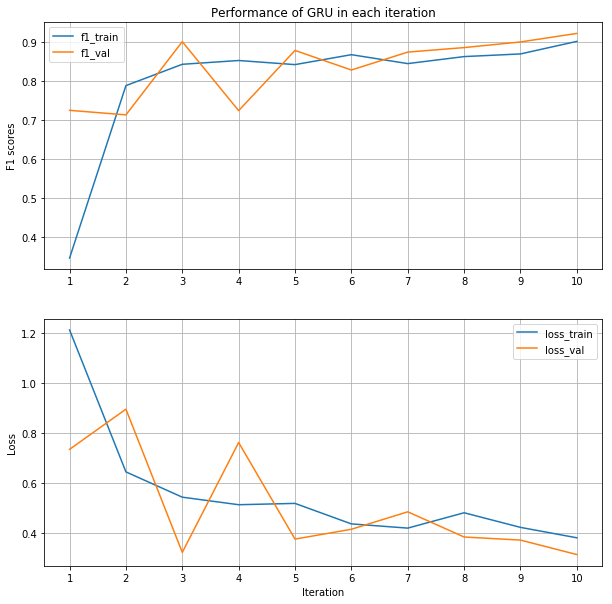

In [21]:
from matplotlib import pyplot as plt

f1_train_2_gru = history_2_gru.history.get('f1')
loss_train_2_gru = history_2_gru.history.get('loss')

f1_val_2_gru = history_2_gru.history.get('val_f1')
loss_val_2_gru = history_2_gru.history.get('val_loss')

iteration = range(1,len(f1_train_2_gru)+1)

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(iteration, f1_train_2_gru, label='f1_train')
plt.plot(iteration, f1_val_2_gru, label='f1_val')
plt.xticks(iteration)
plt.title('Performance of GRU in each iteration')
plt.ylabel('F1 scores')
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.plot(iteration, loss_train_2_gru, label='loss_train')
plt.plot(iteration, loss_val_2_gru, label='loss_val')
plt.xticks(iteration)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.grid()
plt.legend()
plt.show()

## 3rd part

[20 points] Use the method of cross validation and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the RNNs you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  

### LSTM + StratifiedSplit
### Stratified 10-folds split

Since there are only about 2300 samples in our dataset, we decide to use StratifiedSplit method of cross validation in order to get the general performance. We split the data into 10 folds, and train 9 of them each time and use the remaining one to test our model. The StratifiedSplit can make sure that every fold will cover all classes of the dataset labels, and is useful especially for small dataset.

In [22]:
from sklearn.model_selection import StratifiedKFold

# rebulid the LSTM model
rnn_2_lstm = Sequential()
rnn_2_lstm.add(embedding_layer)
rnn_2_lstm.add(CuDNNLSTM(100, return_sequences=True))
# add a second recurrent chain 
rnn_2_lstm.add(CuDNNLSTM(100))
rnn_2_lstm.add(Dense(NUM_CLASSES, activation='softmax'))
rnn_2_lstm.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=[mcor,recall, f1])

# create a stratifiedkfold object
skf = StratifiedKFold(n_splits=10)

cv_training_f1_score = []
cv_training_loss = []

cv_val_f1_score = []
cv_val_loss = []

for train_indices, val_indices in skf.split(X_train, y_train):
    X_tmp_train = X_train[train_indices]
    y_tmp_train = y_train_ohe[train_indices]
    
    X_tmp_val = X_train[val_indices]
    y_tmp_val = y_train_ohe[val_indices]
    
    history_2_lstm = rnn_2_lstm.fit(X_train, y_train_ohe, 
                                  validation_data=(X_test, y_test_ohe), 
                                  epochs=10, batch_size=64)
    
    # save the performance data of different training and validation set
    
    cv_training_f1_score.append(history_2_lstm.history.get('f1'))
    cv_val_f1_score.append(history_2_lstm.history.get('val_f1'))
    
    cv_training_loss.append(history_2_lstm.history.get('loss'))
    cv_val_loss.append(history_2_lstm.history.get('val_loss'))

Train on 1780 samples, validate on 445 samples
Epoch 1/10
1780/1780 [==============================] - 4s 2ms/step - loss: 1.1949 - mcor: 0.3042 - recall: 0.2876 - f1: 0.3433 - val_loss: 0.9639 - val_mcor: 0.5211 - val_recall: 0.5551 - val_f1: 0.6051
Epoch 2/10
1780/1780 [==============================] - 2s 1ms/step - loss: 0.7317 - mcor: 0.6915 - recall: 0.7096 - f1: 0.7478 - val_loss: 0.5202 - val_mcor: 0.7886 - val_recall: 0.7978 - val_f1: 0.8284
Epoch 3/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.7040 - mcor: 0.7226 - recall: 0.7444 - f1: 0.7748 - val_loss: 0.7355 - val_mcor: 0.7294 - val_recall: 0.7685 - val_f1: 0.7821
Epoch 4/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.5009 - mcor: 0.8115 - recall: 0.8320 - f1: 0.8481 - val_loss: 0.2874 - val_mcor: 0.8995 - val_recall: 0.9101 - val_f1: 0.9193
Epoch 5/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.4845 - mcor: 0.8046 - recall: 0.8270 - f1: 0.8424 - val_los

1780/1780 [==============================] - 3s 1ms/step - loss: 0.0975 - mcor: 0.9648 - recall: 0.9708 - f1: 0.9719 - val_loss: 0.1809 - val_mcor: 0.9255 - val_recall: 0.9393 - val_f1: 0.9404
Train on 1780 samples, validate on 445 samples
Epoch 1/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.0852 - mcor: 0.9705 - recall: 0.9758 - f1: 0.9764 - val_loss: 0.1660 - val_mcor: 0.9422 - val_recall: 0.9506 - val_f1: 0.9537
Epoch 2/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.0768 - mcor: 0.9768 - recall: 0.9809 - f1: 0.9814 - val_loss: 0.4117 - val_mcor: 0.9143 - val_recall: 0.9303 - val_f1: 0.9314
Epoch 3/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.0757 - mcor: 0.9779 - recall: 0.9815 - f1: 0.9823 - val_loss: 0.1818 - val_mcor: 0.9394 - val_recall: 0.9483 - val_f1: 0.9515
Epoch 4/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.0769 - mcor: 0.9726 - recall: 0.9775 - f1: 0.9781 - val_loss: 0.1356 -

1780/1780 [==============================] - 3s 1ms/step - loss: 0.0296 - mcor: 0.9919 - recall: 0.9933 - f1: 0.9935 - val_loss: 0.1275 - val_mcor: 0.9691 - val_recall: 0.9753 - val_f1: 0.9753
Epoch 10/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.0044 - mcor: 0.9979 - recall: 0.9983 - f1: 0.9983 - val_loss: 0.2309 - val_mcor: 0.9494 - val_recall: 0.9596 - val_f1: 0.9596
Train on 1780 samples, validate on 445 samples
Epoch 1/10
1780/1780 [==============================] - 3s 1ms/step - loss: 2.6770e-04 - mcor: 1.0000 - recall: 1.0000 - f1: 1.0000 - val_loss: 0.1939 - val_mcor: 0.9607 - val_recall: 0.9685 - val_f1: 0.9685
Epoch 2/10
1780/1780 [==============================] - 3s 1ms/step - loss: 1.0774e-04 - mcor: 1.0000 - recall: 1.0000 - f1: 1.0000 - val_loss: 0.1763 - val_mcor: 0.9607 - val_recall: 0.9685 - val_f1: 0.9685
Epoch 3/10
1780/1780 [==============================] - 3s 1ms/step - loss: 5.4515e-05 - mcor: 1.0000 - recall: 1.0000 - f1: 1.0000 - val_l

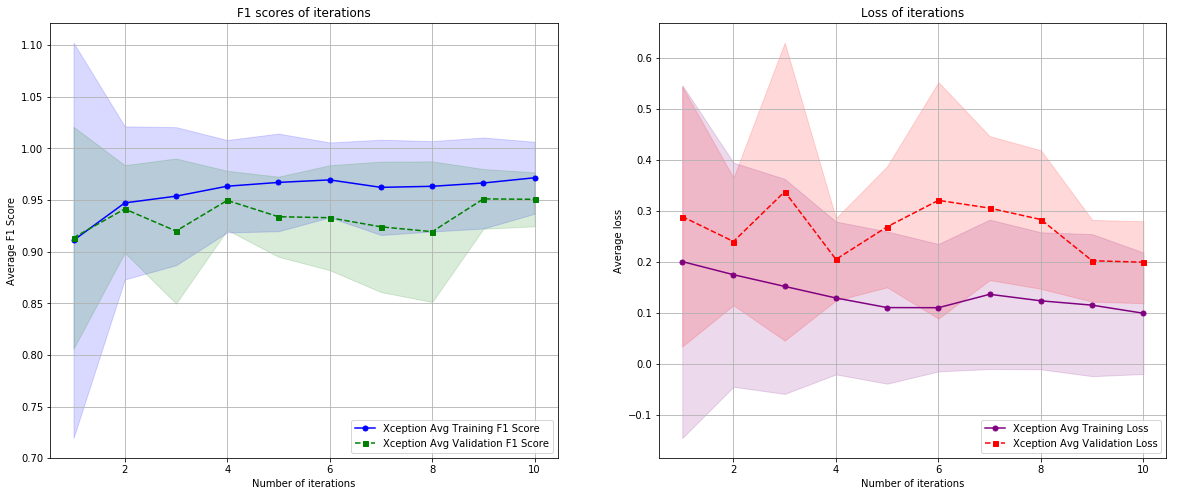

In [23]:
# Visualize the performance of LSTM cross validation

iteration = np.array([i for i in range(1, len(cv_training_f1_score[0])+1)])

cv_training_f1_score_mean = np.mean(np.array(cv_training_f1_score), axis=0)
cv_training_f1_score_std = np.std(np.array(cv_training_f1_score), axis=0)

cv_training_loss_mean = np.mean(np.array(cv_training_loss), axis=0)
cv_training_loss_std = np.std(np.array(cv_training_loss), axis=0)

cv_val_f1_score_mean = np.mean(np.array(cv_val_f1_score), axis=0)
cv_val_f1_score_std = np.std(np.array(cv_val_f1_score), axis=0)

cv_val_loss_mean = np.mean(np.array(cv_val_loss), axis=0)
cv_val_loss_std = np.std(np.array(cv_val_loss), axis=0)

plt.figure(figsize=(20,8))

# f1 scores
plt.subplot(1,2,1)
plt.plot(iteration, cv_training_f1_score_mean, color='blue', 
         marker='o', markersize=5, 
         label='Xception Avg Training F1 Score')

plt.fill_between(iteration, cv_training_f1_score_mean+cv_training_f1_score_std, 
                 cv_training_f1_score_mean-cv_training_f1_score_std, 
                 alpha=0.15, color='blue')

plt.plot(iteration, cv_val_f1_score_mean, color='green', 
         linestyle='--', marker='s', markersize=5, 
         label='Xception Avg Validation F1 Score')

plt.fill_between(iteration, cv_val_f1_score_mean+cv_val_f1_score_std, 
                 cv_val_f1_score_mean-cv_val_f1_score_std, 
                 alpha=0.15, color='green')
plt.title('F1 scores of iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Average F1 Score')
plt.legend(loc='lower right')
plt.grid()

# loss
plt.subplot(1,2,2)
plt.plot(iteration, cv_training_loss_mean, color='purple', 
         marker='o', markersize=5, 
         label='Xception Avg Training Loss')

plt.fill_between(iteration, cv_training_loss_mean+cv_training_loss_std, 
                 cv_training_loss_mean-cv_training_loss_std, 
                 alpha=0.15, color='purple')

plt.plot(iteration, cv_val_loss_mean, color='red', linestyle='--', 
         marker='s', markersize=5, 
         label='Xception Avg Validation Loss')

plt.fill_between(iteration, cv_val_loss_mean+cv_val_loss_std, 
                 cv_val_loss_mean-cv_val_loss_std, 
                 alpha=0.15, color='red')

plt.grid()
plt.title('Loss of iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Average loss')
plt.legend(loc='lower right')
plt.show()


### GRU + StratifiedSplit

In [24]:
from sklearn.model_selection import StratifiedKFold

# rebuild the model
rnn_2_gru = Sequential()
rnn_2_gru.add(embedding_layer)
rnn_2_gru.add(CuDNNLSTM(100, return_sequences=True))
# add a second recurrent chain 
rnn_2_gru.add(CuDNNLSTM(100))

rnn_2_gru.add(Dense(NUM_CLASSES, activation='softmax'))
rnn_2_gru.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=[mcor,recall, f1])

# create a stratifiedkfold object
skf = StratifiedKFold(n_splits=10)


cv_training_f1_score = []
cv_training_loss = []

cv_val_f1_score = []
cv_val_loss = []

for train_indices, val_indices in skf.split(X_train, y_train):
    X_tmp_train = X_train[train_indices]
    y_tmp_train = y_train_ohe[train_indices]
    
    X_tmp_val = X_train[val_indices]
    y_tmp_val = y_train_ohe[val_indices]
    
    history_2_gru = rnn_2_gru.fit(X_train, y_train_ohe, 
                                  validation_data=(X_test, y_test_ohe), 
                                  epochs=10, batch_size=64)
    
    # save the performance data of different training and validation set
    
    cv_training_f1_score.append(history_2_gru.history.get('f1'))
    cv_val_f1_score.append(history_2_gru.history.get('val_f1'))
    
    cv_training_loss.append(history_2_gru.history.get('loss'))
    cv_val_loss.append(history_2_gru.history.get('val_loss'))

Train on 1780 samples, validate on 445 samples
Epoch 1/10
1780/1780 [==============================] - 4s 2ms/step - loss: 1.2594 - mcor: 0.3142 - recall: 0.2669 - f1: 0.3356 - val_loss: 0.6766 - val_mcor: 0.7271 - val_recall: 0.7101 - val_f1: 0.7729
Epoch 2/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.7408 - mcor: 0.6822 - recall: 0.7000 - f1: 0.7394 - val_loss: 0.4947 - val_mcor: 0.7931 - val_recall: 0.8022 - val_f1: 0.8322
Epoch 3/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.5774 - mcor: 0.7743 - recall: 0.7972 - f1: 0.8176 - val_loss: 0.5341 - val_mcor: 0.7931 - val_recall: 0.8225 - val_f1: 0.8338
Epoch 4/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.5091 - mcor: 0.8255 - recall: 0.8517 - f1: 0.8600 - val_loss: 0.3115 - val_mcor: 0.8957 - val_recall: 0.9124 - val_f1: 0.9164
Epoch 5/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.5286 - mcor: 0.7999 - recall: 0.8275 - f1: 0.8390 - val_los

1780/1780 [==============================] - 3s 1ms/step - loss: 0.0895 - mcor: 0.9719 - recall: 0.9753 - f1: 0.9775 - val_loss: 0.0997 - val_mcor: 0.9619 - val_recall: 0.9663 - val_f1: 0.9695
Train on 1780 samples, validate on 445 samples
Epoch 1/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.0801 - mcor: 0.9814 - recall: 0.9843 - f1: 0.9851 - val_loss: 0.1414 - val_mcor: 0.9480 - val_recall: 0.9573 - val_f1: 0.9583
Epoch 2/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.0874 - mcor: 0.9691 - recall: 0.9730 - f1: 0.9752 - val_loss: 0.1364 - val_mcor: 0.9607 - val_recall: 0.9685 - val_f1: 0.9685
Epoch 3/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.0542 - mcor: 0.9803 - recall: 0.9831 - f1: 0.9842 - val_loss: 0.1794 - val_mcor: 0.9325 - val_recall: 0.9438 - val_f1: 0.9459
Epoch 4/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.0635 - mcor: 0.9761 - recall: 0.9803 - f1: 0.9809 - val_loss: 0.2100 -

1780/1780 [==============================] - 3s 1ms/step - loss: 0.0086 - mcor: 0.9979 - recall: 0.9983 - f1: 0.9983 - val_loss: 0.1630 - val_mcor: 0.9494 - val_recall: 0.9596 - val_f1: 0.9596
Epoch 10/10
1780/1780 [==============================] - 3s 1ms/step - loss: 2.4170e-04 - mcor: 1.0000 - recall: 1.0000 - f1: 1.0000 - val_loss: 0.1472 - val_mcor: 0.9607 - val_recall: 0.9685 - val_f1: 0.9685
Train on 1780 samples, validate on 445 samples
Epoch 1/10
1780/1780 [==============================] - 3s 1ms/step - loss: 8.4904e-05 - mcor: 1.0000 - recall: 1.0000 - f1: 1.0000 - val_loss: 0.1412 - val_mcor: 0.9635 - val_recall: 0.9708 - val_f1: 0.9708
Epoch 2/10
1780/1780 [==============================] - 3s 1ms/step - loss: 3.5375e-05 - mcor: 1.0000 - recall: 1.0000 - f1: 1.0000 - val_loss: 0.1655 - val_mcor: 0.9691 - val_recall: 0.9753 - val_f1: 0.9753
Epoch 3/10
1780/1780 [==============================] - 3s 1ms/step - loss: 0.0271 - mcor: 0.9923 - recall: 0.9938 - f1: 0.9938 - val_l

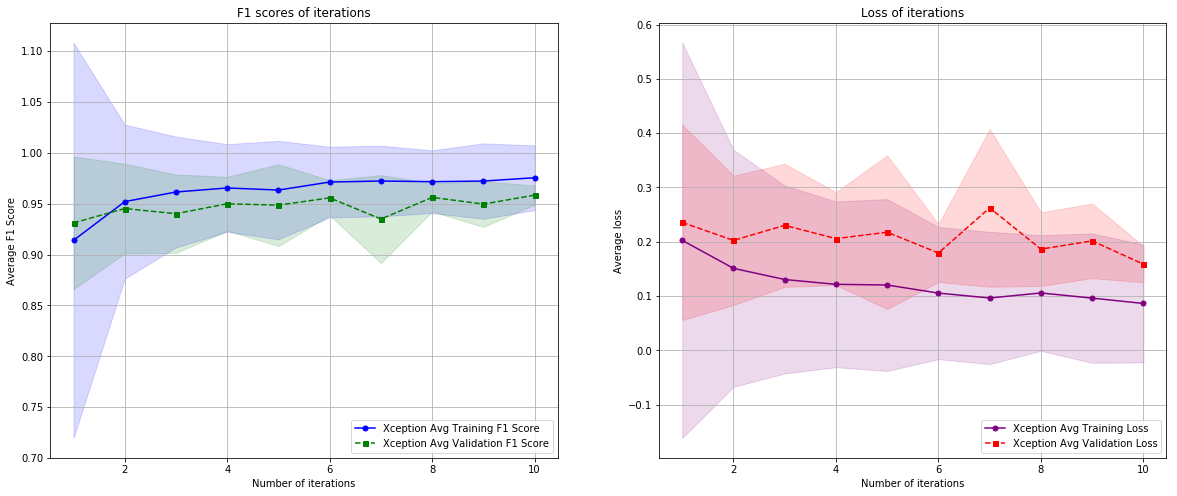

In [25]:
# Visualize the performance of GRU cross validation

iteration = np.array([i for i in range(1, len(cv_training_f1_score[0])+1)])

cv_training_f1_score_mean = np.mean(np.array(cv_training_f1_score), axis=0)
cv_training_f1_score_std = np.std(np.array(cv_training_f1_score), axis=0)

cv_training_loss_mean = np.mean(np.array(cv_training_loss), axis=0)
cv_training_loss_std = np.std(np.array(cv_training_loss), axis=0)

cv_val_f1_score_mean = np.mean(np.array(cv_val_f1_score), axis=0)
cv_val_f1_score_std = np.std(np.array(cv_val_f1_score), axis=0)

cv_val_loss_mean = np.mean(np.array(cv_val_loss), axis=0)
cv_val_loss_std = np.std(np.array(cv_val_loss), axis=0)

plt.figure(figsize=(20,8))

# f1 scores
plt.subplot(1,2,1)
plt.plot(iteration, cv_training_f1_score_mean, color='blue', 
         marker='o', markersize=5, 
         label='Xception Avg Training F1 Score')

plt.fill_between(iteration, cv_training_f1_score_mean+cv_training_f1_score_std, 
                 cv_training_f1_score_mean-cv_training_f1_score_std, 
                 alpha=0.15, color='blue')

plt.plot(iteration, cv_val_f1_score_mean, color='green', 
         linestyle='--', marker='s', markersize=5, 
         label='Xception Avg Validation F1 Score')

plt.fill_between(iteration, cv_val_f1_score_mean+cv_val_f1_score_std, 
                 cv_val_f1_score_mean-cv_val_f1_score_std, 
                 alpha=0.15, color='green')
plt.title('F1 scores of iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Average F1 Score')
plt.legend(loc='lower right')
plt.grid()

# loss
plt.subplot(1,2,2)
plt.plot(iteration, cv_training_loss_mean, color='purple', 
         marker='o', markersize=5, 
         label='Xception Avg Training Loss')

plt.fill_between(iteration, cv_training_loss_mean+cv_training_loss_std, 
                 cv_training_loss_mean-cv_training_loss_std, 
                 alpha=0.15, color='purple')

plt.plot(iteration, cv_val_loss_mean, color='red', linestyle='--', 
         marker='s', markersize=5, 
         label='Xception Avg Validation Loss')

plt.fill_between(iteration, cv_val_loss_mean+cv_val_loss_std, 
                 cv_val_loss_mean-cv_val_loss_std, 
                 alpha=0.15, color='red')

plt.grid()
plt.title('Loss of iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Average loss')
plt.legend(loc='lower right')
plt.show()


### Use proper statistic comparison technics to determine which method is superior

Confusion matrix?

In [26]:
from sklearn.metrics import confusion_matrix

y_pred_gru = rnn_2_gru.predict(X_test)
y_pred_gru = [np.argmax(t) for t in y_pred_gru]
y_expec_gru = [np.argmax(t) for t in y_test_ohe]
print('GRU Confusion Matrix')
print(confusion_matrix(y_expec_gru, y_pred_gru),'\n')

y_pred_lstm = rnn_2_lstm.predict(X_test)
y_pred_lstm = [np.argmax(t) for t in y_pred_lstm]
y_expec_lstm = [np.argmax(t) for t in y_test_ohe]
print('LSTM Confusion Matrix')
print(confusion_matrix(y_expec_gru, y_pred_lstm))

GRU Confusion Matrix
[[ 96   0   5   0   1]
 [  0  75   0   2   0]
 [  4   1  79   0   0]
 [  0   0   0 102   0]
 [  3   0   1   0  76]] 

LSTM Confusion Matrix
[[ 98   0   4   0   0]
 [  0  76   1   0   0]
 [  6   1  77   0   0]
 [  0   0   1 101   0]
 [  1   0   0   0  79]]


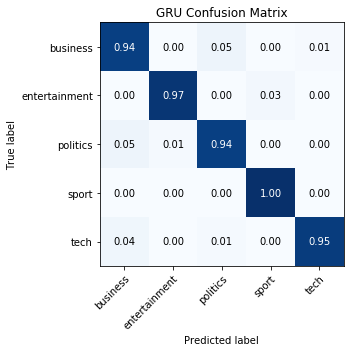

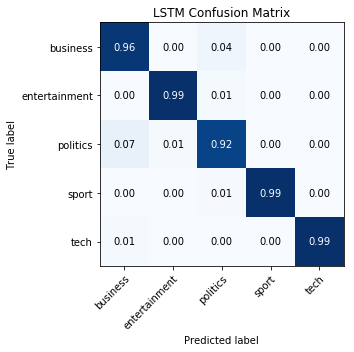

In [27]:
# Code to plot confusion matrix in a color map from Sklearn examples
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot normalized GRU confusion matrix
plot_confusion_matrix(y_expec_gru, y_pred_gru, classes=CLASSES, normalize=True,
                      title='GRU Confusion Matrix')

# Plot normalized LSTM confusion matrix
plot_confusion_matrix(y_expec_lstm, y_pred_lstm, classes=CLASSES, normalize=True,
                      title='LSTM Confusion Matrix')

plt.show()

Actually, from the confusion matrix color map above, we couldn't see much difference between 2-chain-LSTM and 2-chain-GRU and they both did a wonderful job when classifying text data. When classifying 'business' and 'politics' news, LSTM have a little bit of advantage over GRU. But the situation is opposite when classifying the 'entertainment' and 'tech' news.

## Exceptional Work

Use t-SNE (or SVD) to visualize the word embeddings of a subset of words in your vocabulary. Try to interpret what each dimension reflects (in your own words). That is, try to explain what aspect of the language is encoded in the reduced dimensionality embedding. 

In [28]:
# %%time
# # use glove.100d, so the EMBED_SIZE should be the same (100)
# EMBED_SIZE = 100

# embeddings_index = {}
# f = open('glove.6B/glove.6B.100d.txt', encoding='utf-8')
# # save key/array pairs of the embeddings
# # the key of the dictionary is the word, the array is the embedding

# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# print('Found %s word vectors.' % len(embeddings_index))

In [29]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(embedding_matrix[200:300])

CPU times: user 7.66 s, sys: 2.13 s, total: 9.78 s
Wall time: 3.07 s


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.043s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 1.651393
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.899529
[t-SNE] Error after 1000 iterations: 1.113145


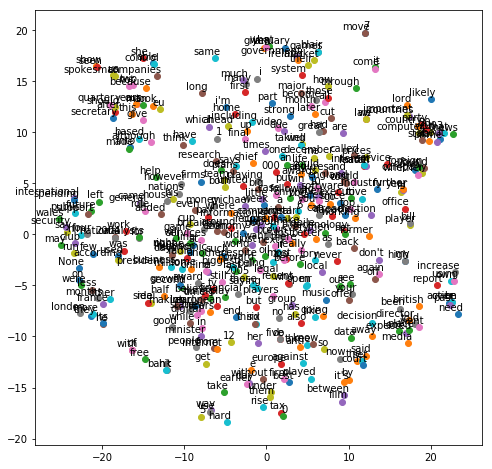

In [32]:
from time import time
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, verbose=1, init='pca')
X_tsne = tsne.fit_transform(embedding_matrix[200:600])

def search_word(mydict, need_index):
    for word, index in mydict.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
        if index == need_index:
            return word

plt.figure(figsize=(8,8))

for i in range(len(X_tsne)):
    plt.scatter(X_tsne[i][0], X_tsne[i][1])
    word = search_word(word_index, i)
    plt.annotate(word, xy=(X_tsne[i][0], X_tsne[i][1]),
                xytext=(5,2),
                textcoords='offset points',
                ha='right',
                va='bottom')